# Homeowners vs. Student Loan Holders

# Imports

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

In [2]:
# Import "cleaned_dataframe"
cldf = pd.read_csv('./data/cleaned_dataframe.csv')


# Build, Fit, Score, and Tune Models
LogisticRegression
1. Pre-processing
2. Build and fit model
3. Score model
4. Tune Model

## 1. Pre-processing

In [3]:
# Create a baseline
baseline = cldf['subreddit'].value_counts(normalize=True)
baseline

0    0.598622
1    0.401378
Name: subreddit, dtype: float64

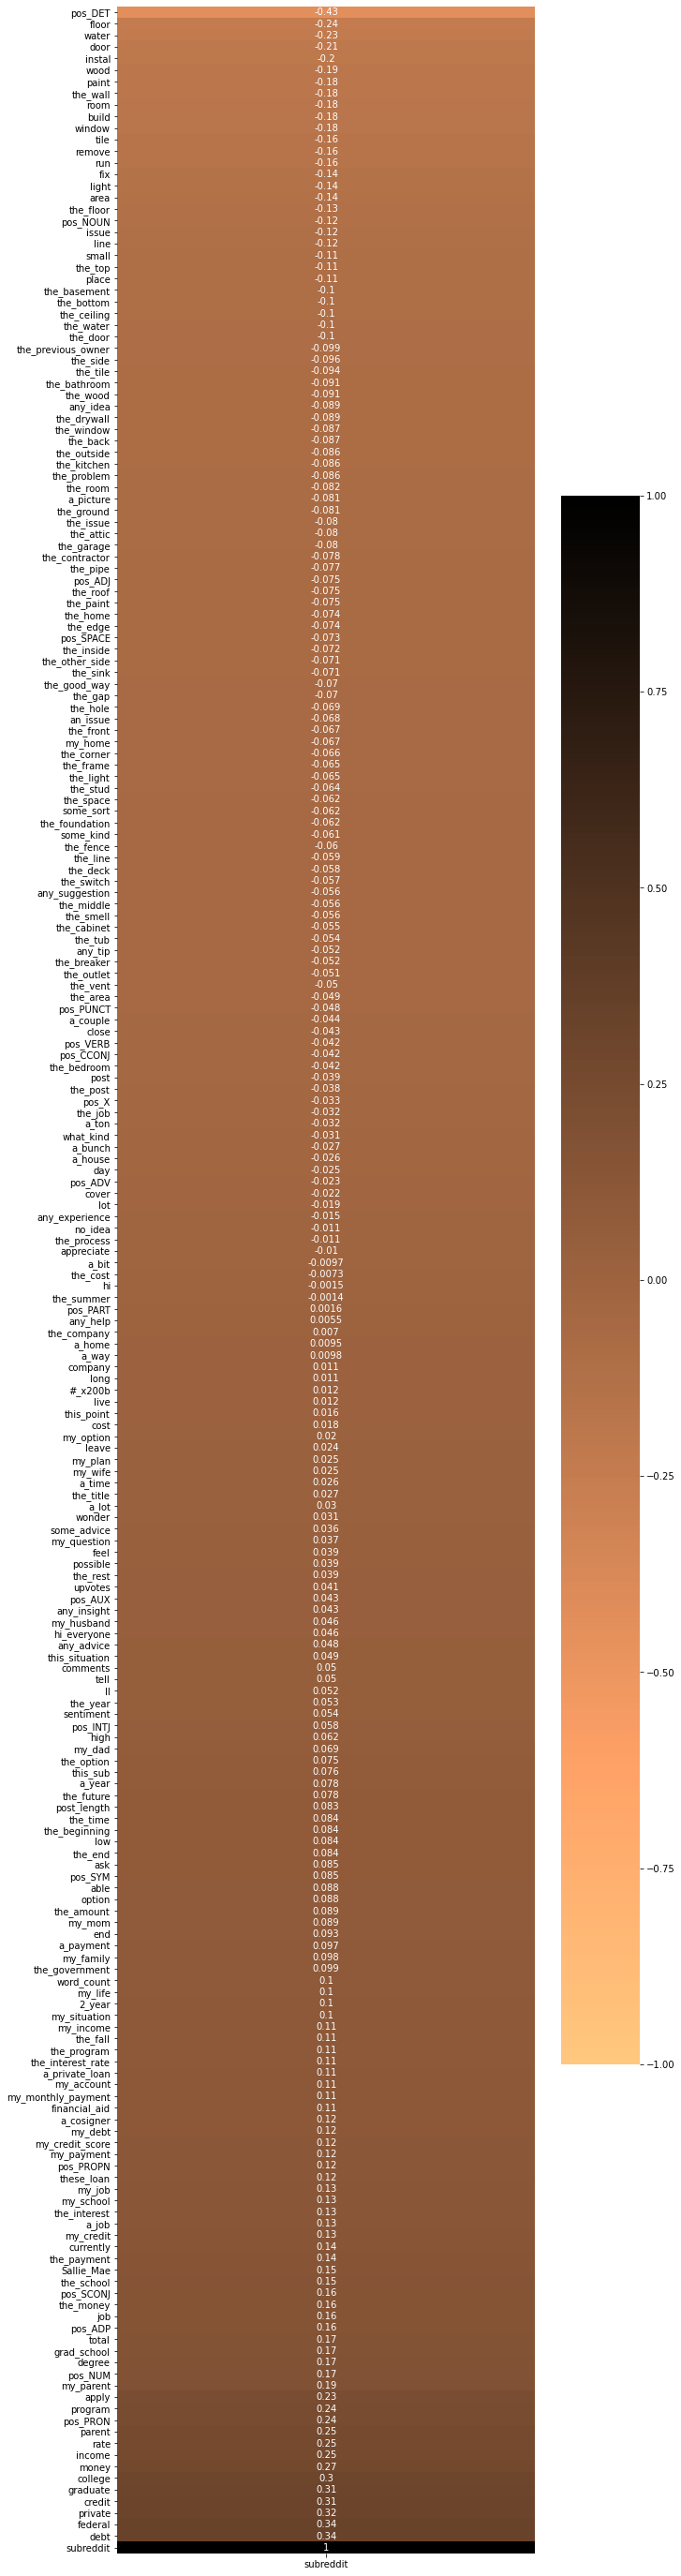

In [4]:
figure, ax = plt.subplots(1,1, figsize=(10,50))
sns.heatmap(cldf.corr()[['subreddit']].sort_values('subreddit'),
           annot=True,
           cmap = 'copper_r',
           vmin=-1,
           vmax=1);

In [5]:
# Establish X,y
X = cldf.drop(columns=['subreddit', 'ids', 'body', 'lemma_body', 'title'])
y = cldf['subreddit']

In [6]:
# Create train/test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=23, test_size=.2, stratify=y)

## 2. Build and fit model

In [7]:
# Logistic Regression Pipeline
logr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('logr', LogisticRegression())
])

In [8]:
# KNN Pipeline
knn_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [137]:
# Vote Classifier
vote = VotingClassifier([
    ('rfc', RandomForestClassifier()),
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('knn_pipe', knn_pipe),
    ('logr_pipe', logr_pipe)
])

In [138]:
# Vote Params
grid_params = {
    'rfc__n_estimators': [150],
    'rfc__max_depth': [35],
    'rfc__class_weight': ['balanced'],
    'ada__n_estimators': [70],
    'gb__max_depth': [10],
    'gb__n_estimators': [125],
    'knn_pipe__knn__p': [2],
    'knn_pipe__knn__weights': ['distance'],
    'knn_pipe__knn__n_neighbors': [20],
    'logr_pipe__logr__penalty': ['l2'],
    'logr_pipe__logr__C': [10],
    'logr_pipe__logr__solver': ['liblinear']
}

In [139]:
# Instantiate GridSearchCV
vote_gridSCV = GridSearchCV(vote,
                            grid_params,
                            cv=5
                           )

In [140]:
# Fit Model
vote_gridSCV.fit(X_train, y_train)
# Filter out warnings for model params
warnings.filterwarnings('ignore')

## 3. Score model

In [141]:
vote_gridSCV.score(X_train, y_train), vote_gridSCV.score(X_test, y_test)

(1.0, 0.9891732283464567)

In [142]:
vote_gridSCV.best_params_

{'ada__n_estimators': 70,
 'gb__max_depth': 10,
 'gb__n_estimators': 125,
 'knn_pipe__knn__n_neighbors': 20,
 'knn_pipe__knn__p': 2,
 'knn_pipe__knn__weights': 'distance',
 'logr_pipe__logr__C': 10,
 'logr_pipe__logr__penalty': 'l2',
 'logr_pipe__logr__solver': 'liblinear',
 'rfc__class_weight': 'balanced',
 'rfc__max_depth': 35,
 'rfc__n_estimators': 150}

In [143]:
vote_gridSCV.best_score_

0.9766255248759383

## 4. Tune Model

Tuning Process:
1. Commented in various models into my VotingClassifier and tuned individually
2. Once good params were found for individual models I combined models in the VotingClassifier
3. Results of all notable Model tuning:

    1. RandomForestClassifier initial grid_params:
    * 'n_estimators': [75,100.125],
    * 'max_depth': [10, 20,30],
    * 'class_weight': [None, 'balanced']
    * Results: 
        1. TrainScore: 1.0
        2. TestScore: .984
        3. Best Score: .976
        4. Best Params: n_estimators = 125, max_depth = 30, class_weight = 'balanced
    2. AdaBoostClassifier initial grid_params:
    * 'n_estimators': [40,50,60],
    * Results:
        1. TrainScore: .959
        2. TestScore: .954
        3. Best Score: .938
        4. Best Params: n_estimators = 60
    3.  GradientBoostingClassifier initial grid_params:
    * 'n_estimators': [75,100,125],
    * 'max_depth': [1,3,5],
    * Results:
        1. TrainScore: .995
        2. TestScore: .977
        3. Best Score: .963
        4. Best Params: n_estimators = 125, max_depth = 5
    4. KNeighborsClassifier initial grid_params:
    * 'p': [1,2],
    * 'weights': ['uniform', 'distance'],
    * 'n_neighbors': [5, 10, 15, 20],
    * Results:
        1. TrainScore: 1.0
        2. TestScore: .971
        3. Best Score: .951
        4. Best Params: n_neighbors = 20, p = 2, weights = 'distance'
    5. LogisticRegressor initial grid_params:
    * 'penalty': ['l1','l2', 'elasticnet'],
    * 'C': [8, 9, 10, 11, 12],
    * 'solver': ['liblinear']
    * Results:
        1. TrainScore: .969
        2. TestScore: .958
        3. Best Score: .948
        4. Best Params: penalty = 'l2', 'C' = 10, 'solver' = 'liblinear'
   
4. Second Round of grid:
        
    1. RandomForestClassifier second grid_params:
    * 'n_estimators': [125, 150],
    * 'max_depth': [30, 35],
    * 'class_weight': ['balanced']
    * Results: 
        1. TrainScore: 1.0
        2. TestScore: .983
        3. Best Score: .976
        4. Best Params: n_estimators = 150, max_depth = 35, class_weight = 'balanced
    2. AdaBoostClassifier initial grid_params:
    * 'n_estimators': [55,60,65,70],
    * Results:
        1. TrainScore: .965
        2. TestScore: .955
        3. Best Score: .942
        4. Best Params: n_estimators = 70
    3.  GradientBoostingClassifier initial grid_params:
    * 'n_estimators': [125,150],
    * 'max_depth': [5,10],
    * Results:
       1. TrainScore: 1.0
        2. TestScore: .986
        3. Best Score: .969
        4. Best Params: n_estimators = 125, max_depth = 10
    4. KNeighborsClassifier initial grid_params:
    * 'p': [2],
    * 'weights': ['distance'],
    * 'n_neighbors': [20,25,30],
    * Results:
        1. TrainScore: 1.0
        2. TestScore: .971
        3. Best Score: .951
        4. Best Params: n_neighbors = 20, p = 2, weights = 'distance'
    5. LogisticRegressor initial grid_params:
    * 'penalty': ['l2'],
    * 'C': [10],
    * 'solver': ['liblinear']
    * Results:
        1. TrainScore: .969
        2. TestScore: .958
        3. Best Score: .948
        4. Best Params: penalty = 'l2', 'C' = 10, 'solver' = 'liblinear'
        
5. Model combinations with best params from previous steps:

    1. GradientBoostingClassifier and RandomForestClassifier
    * Results:
        1. TrainScore: 1.0
        2. TestScore: .982
        3. Best Score: .976
    2. GradientBoostingClassifier, RandomForestClassifier, LogisticRegressor
    * Results:
        1. TrainScore: 1.0
        2. TestScore: .989
        3. Best Score: .974
    3. AdaBoostClassifier, RandomForestClassifier, LogisticRegressor
    * Results:
        1. TrainScore: .986
        2. TestScore: .972
        3. Best Score: .964
    4. GradientBoostingClassifier, KNeighborsClassifier, LogisticRegressor
    * Results:
        1. TrainScore: 1.0
        2. TestScore: .988
        3. Best Score: .975
    5. GradientBoostingClassifier, RandomForestClassifier, KNeighborsClassifier, LogisticRegressor
    * Results:
        1. TrainScore: 1.0
        2. TestScore: .984
        3. Best Score: .976
    5. All 5 models
    * Results:
        1. TrainScore: 1.0
        2. TestScore: .989
        3. Best Score: .976
    
   

# Production Model and Insights
1. Models and Params
2. Predictions from Production Model
3. Insights

## 1. Models and Params

Final Model:

Voting Classifier using all 5 models had a Train Score of 1.0, Test Score of .989, and a Best Score of .976

Parameters have been updated in the VotingClassifier

## 2. Predictions from Production Model

In [146]:
preds = pd.DataFrame(vote_gridSCV.predict(X_test))

In [145]:
preds

,0
0,0
1,1
2,1
3,0
4,0
...,...
1011,0
1012,0
1013,0
1014,0


## 3. Insights
1. Sentiment
2. Parts of Speech
3. Average Word Count
4. Frequently Used Words
5. Frequently Used Noun Chunks

### Sentiment

Hypothesis tests showed with 99% confidence that the r/StudentLoan subreddit averaged a more positive sentiment score:

1. HomeImprovement = .8
2. StudentLoans = .9

### Parts of Speech

Proper Nouns usage frequency showed the most discrepency in favor of the Student Loans subreddit

Spacy's "X" part of speech means "other" and showed the most discrepency in favor of the Home Improvement subreddit

### Average Word Count

Hypothesis tests showed with 99% confidence that the r/StudentLoan subreddit averaged more words per post

Average word count was about 20 higher per post in the Student Loan subreddit

### Frequently Used Words

Words having to do with house parts/materials such as "door", "floor", "paint", "wood", and "window" were the most indicative of belonging to the Home Improvement subreddit. However, the most indicative word was "water".

Words having to do with "college", "federal", "debt", "credit", "private", "money", and "graduate" were some of the most frequently used words for the Student Loan subreddit after limiting for leakers and filler words. 

### Frequently Used Terms

Similar to words, terms having to do with house parts/materials tended to be most indicative of inclusion in the Home Improvement subreddit

Of the frequently used terms school, money, and parents were the most indicative of inclusion in the Student Loan subreddit.

One of the most interesting discoveries are that terms having to do with a spounse were almost evenly split. It would have seemed likely the Home Improvement subreddit would mention these terms more frequntly because they are generally in a more advanced stage of life.

Another interesting discovery was that the terms "a house" and "a home" are almost neutral while other terms including the word house such as "the house", "our house" and "my house" are stronger indicators of a post being from the Home Improvement subreddit. This gives some indication that people with Student Loans are at least mentioning Homes/Houses which could indicate that they are making plans for buying at some point if they don't already own.

And finally, the "loan" terms. The loan terms are potantial leakers as they include one of the words from title of the Student 'Loan' subreddit. However, I did do some analysis of these before determining they were leakers and removing them and it turns out that it was a VERY strong leaker, heavily favoring the Student Loan subreddit. This supports the assertion by the Home Improvement Survey cited in the introductory notebook that homeowners may not currently be considering loans for home imporvement projects. 

# Recommendations

1. Use the combination of all 5 models for predictions
2. When analyzing consider the terms and words above all other factors
3. Terms "a home" and "a house" close to balanced between the two subreddits, but considering that almost all other house/home terms had to be excluded as leakers it is indicative that Student Loan holders are mentioning housing and may very well be interested in buying in the future.
4. Use model of other subreddits or other forum text to indicate whether a poster may be in one of these groups.

# References

1. Home Improvement Subreddit - https://www.reddit.com/r/HomeImprovement/new/
2. Student Loan Subreddit - https://www.reddit.com/r/StudentLoans/new/
3. Student Loan Debt and Housing Report 2017 - https://cdn.nar.realtor/sites/default/files/documents/2017-student-loan-debt-and-housing-09-26-2017.pdf
4. Home Improvement Survey - https://www.bankrate.com/loans/personal-loans/coronavirus-loans-home-improvement-survey/
5. Ignore Warnings = Peter Yonka, multiple warnings during GridSearch phase
6. Spacy Parts of Speach Guide - https://ashutoshtripathi.com/2020/04/13/parts-of-speech-tagging-and-dependency-parsing-using-spacy-nlp/
7. Average Credit Card Rates - https://www.thebalance.com/average-credit-card-interest-rate-february-2021-5120542#:~:text=The%20average%20credit%20card%20interest%20rate%20was%20a,purchase%20or%20balance%20transfer%20interest-rate%20changes%20in%20February.
8. Home Equity Rates - https://www.valuepenguin.com/mortgages/average-home-equity-loan-rates